# Pull-Up Rate EDA and Model
In this notebook, I will explore the relationships of different player stats and their future pull-up rate.  

Goals:
- Look for what stats might best predict pull-up rate.
- Find the best model to make accurate predictions.

Conclusions: 
- Like other rates, future pull-up rates are almost entirely related to past pull-up rates.

## 0. Importing Libraries and Data

In [2]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['PULL_UP_FGA'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [9]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['PULL_UP_RATE'])

In [10]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_PULL_UP_RATE']]
X = data.drop(columns='TARGET_PULL_UP_RATE')

#### Splitting X and y into train, validate, and test sets

In [11]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'PULL_UP_RATE')

## 2. Determine Potential Features
- Shooting off the dribble rates are clearly important
- Some of the stats are related to players who have the ball a lot (seconds per touch, usage)
- Passes received is an interesting one as it might indicate a primary ball handler on the team

#### Finding correlated features

In [12]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [13]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [14]:
# Looking at the most correlated features with the target
corr_features

['PULL_UP_FGA_PER_MIN_WEIGHTED',
 'PULL_UP_RATE_WEIGHTED',
 'PULL_UP_FGA_PER_MIN',
 'PULL_UP_RATE',
 'PULL_UP_FGM_PER_MIN_WEIGHTED',
 'PULL_UP_FGM_PER_MIN',
 'PULL_UP_PTS_PER_MIN_WEIGHTED',
 'PULL_UP_PTS_PER_MIN',
 'PULL_UP_FGA_WEIGHTED',
 'PULL_UP_PTS_WEIGHTED']

In [18]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_PULL_UP_RATE'], alpha=.5)

#### Graphing correlated features

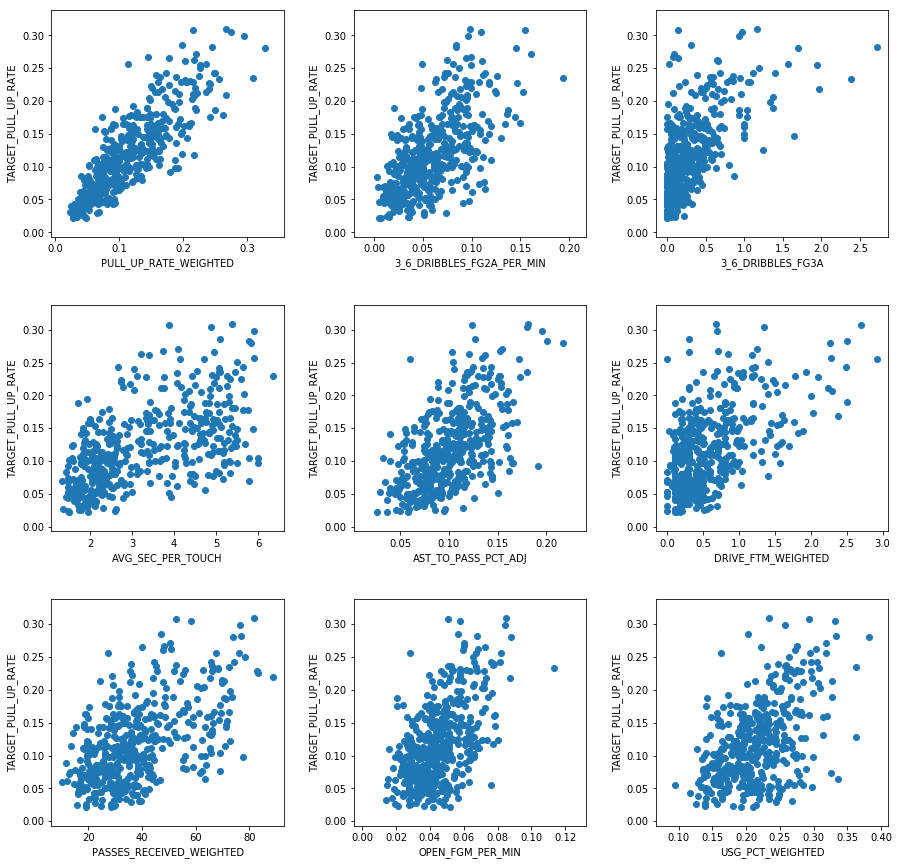

In [19]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

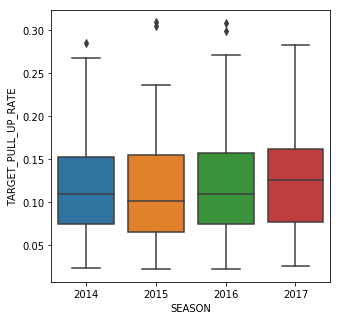

In [21]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

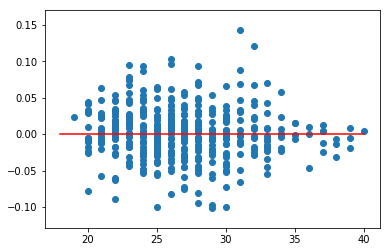

In [22]:
plt.scatter(X_train['AGE'], y_train['TARGET_PULL_UP_RATE'] - X_train['PULL_UP_RATE'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used significantly more features than any of the previous model (for other targets).
- Score was high compared to past model (for other targets).

In [23]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

20

In [24]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['TIGHT_FGA_FREQUENCY', 'TIGHT_FG2A_FREQUENCY', 'TIGHT_FG3A_FREQUENCY',
       'DRIVE_PF_PER_MIN', 'DIST_MILES_PER_MIN', 'DIST_MILES_OFF_PER_MIN',
       'DIST_MILES_DEF_PER_MIN', 'VERY_TIGHT_FGA_PER_MIN',
       'VERY_TIGHT_FG2A_PER_MIN', 'VERY_TIGHT_FG3A_PER_MIN',
       '1_DRIBBLE_FGM_PER_MIN', '1_DRIBBLE_FG2M_PER_MIN',
       '1_DRIBBLE_FG3M_PER_MIN', '3_6_DRIBBLES_FGA_PER_MIN',
       '3_6_DRIBBLES_FG2A_PER_MIN', '3_6_DRIBBLES_FG3A_PER_MIN',
       'DIST_MILES_PER_MIN_WEIGHTED', 'DIST_MILES_OFF_PER_MIN_WEIGHTED',
       'DIST_MILES_DEF_PER_MIN_WEIGHTED', 'ELBOW_TOUCH_FTM_PER_MIN_WEIGHTED'],
      dtype='object')

In [25]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.5911513745086661

#### K BEST
- Surprisingly, the scores got worse as the number of features increased.
- Just using the current season driving rate seemed to get the best score.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

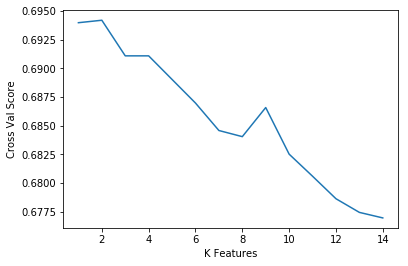

In [29]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 15):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 15), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

1  Feature Cross Val Scores:  [0.60928425 0.69379734 0.65588989 0.74574139 0.76521127]
2  Feature Cross Val Scores:  [0.60928425 0.69379734 0.65696207 0.74574139 0.76521127]
3  Feature Cross Val Scores:  [0.60783041 0.69323218 0.65506764 0.73589788 0.7634334 ]
4  Feature Cross Val Scores:  [0.60783041 0.69323218 0.65506764 0.73589788 0.7634334 ]
5  Feature Cross Val Scores:  [0.61085366 0.68808585 0.6441286  0.73774725 0.7643524 ]
6  Feature Cross Val Scores:  [0.58620422 0.693865   0.65133728 0.74762575 0.75584102]
7  Feature Cross Val Scores:  [0.58658027 0.67987395 0.65239359 0.75001756 0.75402885]
8  Feature Cross Val Scores:  [0.57764314 0.68129861 0.65304347 0.75209707 0.75613498]


/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_select

9  Feature Cross Val Scores:  [0.58229695 0.68927972 0.64313589 0.75920638 0.75899063]
10  Feature Cross Val Scores:  [0.5764929  0.68898796 0.64914885 0.73514476 0.76280476]
11  Feature Cross Val Scores:  [0.57856537 0.69098116 0.64787904 0.73195022 0.7535713 ]


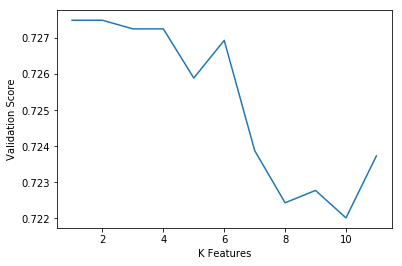

In [31]:
# Checking out 5 - 10 features
k_scores = []
for k in range(1,12):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(1, 12), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [32]:
# Printing out the scores with 5 features
k_best = SelectKBest(f_regression, k=4)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.7272534942345936

In [34]:
# Printing the model features
model_features

['PULL_UP_RATE',
 'PULL_UP_FGA_PER_MIN',
 'PULL_UP_RATE_WEIGHTED',
 'PULL_UP_FGA_PER_MIN_WEIGHTED']

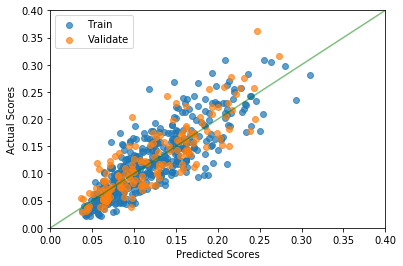

In [35]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### PCA
- The elbow method (pusing 2 features in this case) worked reasonably well.
- The model was clearly worse than others.

In [73]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.30826449, 0.1732889 , 0.08179022, 0.04241663, 0.03020846,
       0.02751924, 0.02200916, 0.0176656 , 0.01590316, 0.01411791,
       0.01377726, 0.01196729, 0.01137253, 0.00978793, 0.00892614])

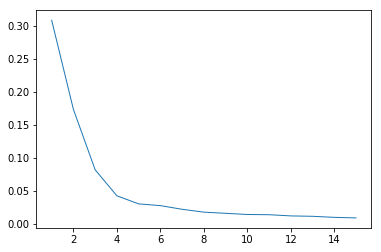

In [74]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [80]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.47194383, 0.59583474, 0.46333217, 0.53240494, 0.59955043])

In [76]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.4965952673715438

#### Neural Net
- Graph has a strange pattern. Higher predicted scores were too low.
- Performed better than past neural nets, but was still not as good as other models.

In [39]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [40]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [41]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [42]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

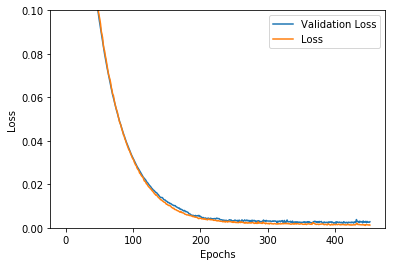

In [43]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [44]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.3528369675352445

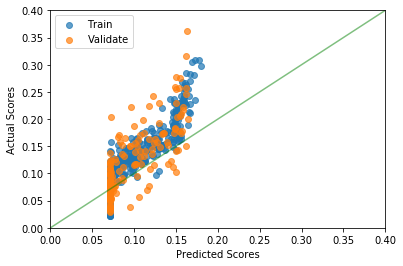

In [45]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the 1 feature model.

In [46]:
# Saving the model features
model_features = ['PULL_UP_EV_WEIGHTED', 'CATCH_SHOOT_EV', 'CATCH_SHOOT_RATE_WEIGHTED', 'DRIVE_RATE_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PULL_UP_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015',
                  '2016', '2017']

In [47]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.62580558, 0.70169466, 0.63471956, 0.76120895, 0.74381608])

In [48]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.7135542772443719

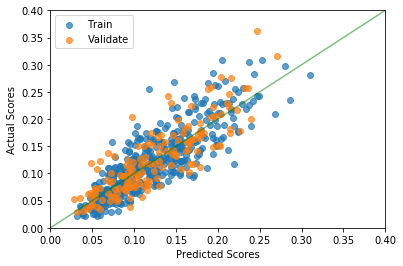

In [49]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=.4)

#### Regularized Linear Regression with My Selected Features
- These scores are slightly improved compared to the linear regression.
- Drive rate in the current season dominated both of their predictions.

In [50]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [51]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.63232562, 0.70195438, 0.63293919, 0.76010387, 0.74372962])

In [58]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.711055968816425

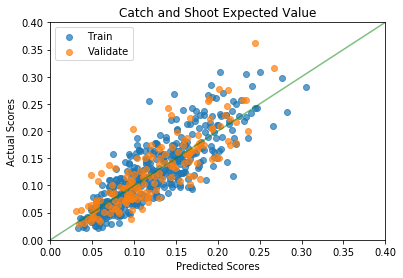

In [59]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=.4)
plt.title('Catch and Shoot Expected Value');

In [60]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.61604673, 0.66047313, 0.63961702, 0.71604126, 0.70884457])

In [61]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.6990659141173081

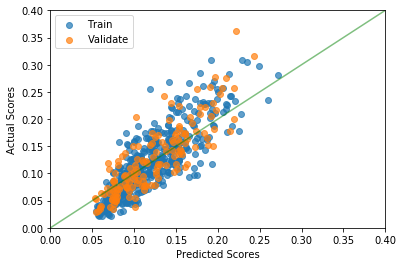

In [62]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=.4)

In [63]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
PULL_UP_EV_WEIGHTED,0.000000,0.000946
CATCH_SHOOT_EV,0.000000,0.003152
CATCH_SHOOT_RATE_WEIGHTED,-0.000000,-0.001299
DRIVE_RATE_WEIGHTED,0.000000,0.005089
POST_TOUCH_RATE_WEIGHTED,-0.000000,0.004117
PULL_UP_RATE_WEIGHTED,0.040931,0.044129
PLAYER_HEIGHT_INCHES,-0.000000,-0.004649
SKINNY,0.000000,0.000342
AGE,-0.000000,-0.003746
2015,-0.000000,-0.003140


#### Final scores (Ridge)
- The r2 score on the test set was lower than the better of the cross validation scores.
- There was a 6.5 percent improvement in the rmse compared to the baseline using the test set.

In [64]:
# Linear model score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.7829681679698608

In [65]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.031126482438653482

In [67]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['PULL_UP_RATE']) ** .5
baseline

0.03228770221523605

In [68]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.03596476977028762

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [69]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_PULL_UP_RATE'] = ridge.predict(X_train_scaled)

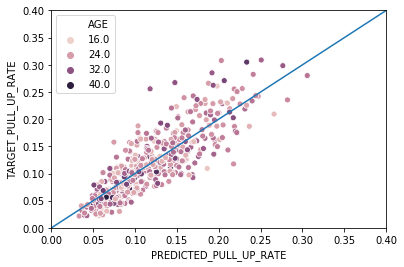

In [70]:
sns.scatterplot('PREDICTED_PULL_UP_RATE', 'TARGET_PULL_UP_RATE', data=train, hue='AGE')
plt.plot([0,.4], [0,.4])
plt.xlim(0, .4)
plt.ylim(0, .4);